In [71]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization, MaxPooling2D
from librosa.core import stft
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
import datagen
import wavload
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [111]:
#20000 + 33000 + 6500 = 59500

num_data = 59500 #6000 for validation, 53500 for training
num_params = 16
samp_length = 67584

X_data = np.zeros(shape=(num_data,samp_length))
print(X_data.shape)

for r in range(0, num_data):
    if r < 20000:
        audio = wavload.readwav('/Users/josephcleveland/Downloads/EvenMoreFMData/' + str(r) + '.wav')[2]
    elif r < 53000:
        audio = wavload.readwav('/Users/josephcleveland/FMData/samp' + str(r - 20000) + '.wav')[2]
    else:
        audio = wavload.readwav('/Users/josephcleveland/MoreFMData/samp' + str(r - 53000) + '.wav')[2]
    audio = audio.T[0]
    if(audio.shape[0] < samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    else:
        audio = audio[0:samp_length]
    X_data[r] = audio
    

(59500, 67584)


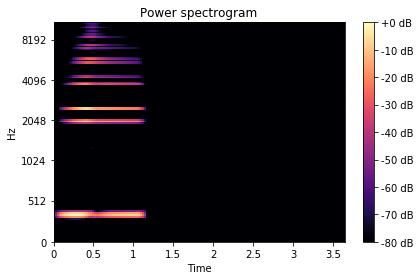

In [108]:
Spectogram = np.abs(librosa.feature.melspectrogram(X_data[100], sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [109]:
Y_data = np.zeros(shape=(num_data))
mat1 = np.genfromtxt('/Users/josephcleveland/Downloads/EvenMoreFMData/m.txt', delimiter=',')
mat2 = np.genfromtxt('/Users/josephcleveland/FMData/mat.txt', delimiter=',')
mat3 = np.genfromtxt('/Users/josephcleveland/MoreFMData/mat.txt', delimiter=',')

Y_data = np.concatenate((mat1[0:20000], mat2[0:33000], mat3[0:6500]))
Y_train = Y_data
print(Y_train.shape)
#for i in range(0, 10000):
#    onehot = to_categorical(mat[i], 16)
#    Y_data[i] = onehot.ravel()

(59500, 16)


In [110]:

X_train = np.zeros((num_data, 64, 64))
for i in range(0, num_data):
    X_train[i] = stft(X_data[i],n_fft=1408)[0:64, 0:64]
X_train = np.expand_dims(X_train, axis=3)

Y_train[:, 0] = Y_train[:, 0]/32
print(X_train.shape)
print(Y_train.shape)
print(Y_train[:, 0])

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


(59500, 64, 64, 1)
(59500, 16)
[0.125   0.15625 0.5     ... 0.125   0.8125  0.78125]


In [116]:
inputs = Input(shape=(64,64,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(98, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(294, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Convolution2D(128, kernel_size=(4, 6), strides=(3, 5), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(16)(x)
# This creates a model that includes
# the Input layer and three Dense layers
adam = optimizers.Adam(lr=0.0001)
model = Model(inputs=inputs, outputs=x)
model.compile(adam,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [117]:
model.fit(X_train[0:53500], Y_train[0:53500], 
          batch_size=16, epochs=40, verbose=1, validation_split=0.1)

Train on 48150 samples, validate on 5350 samples
Epoch 1/40
48150/48150 [==============================] - 606s 13ms/sample - loss: 0.0600 - accuracy: 0.1886 - val_loss: 0.0531 - val_accuracy: 0.2187
Epoch 2/40
48150/48150 [==============================] - 583s 12ms/sample - loss: 0.0507 - accuracy: 0.2276 - val_loss: 0.0485 - val_accuracy: 0.2523
Epoch 3/40
48150/48150 [==============================] - 34618s 719ms/sample - loss: 0.0471 - accuracy: 0.2468 - val_loss: 0.0459 - val_accuracy: 0.2641
Epoch 4/40
48150/48150 [==============================] - 573s 12ms/sample - loss: 0.0443 - accuracy: 0.2636 - val_loss: 0.0450 - val_accuracy: 0.2712
Epoch 5/40
48150/48150 [==============================] - 570s 12ms/sample - loss: 0.0420 - accuracy: 0.2742 - val_loss: 0.0439 - val_accuracy: 0.2789
Epoch 6/40
48150/48150 [==============================] - 564s 12ms/sample - loss: 0.0398 - accuracy: 0.2831 - val_loss: 0.0432 - val_accuracy: 0.2819
Epoch 7/40
48150/48150 [==================

In [76]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 98)        28322     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 98)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 294)       2596

In [113]:
o = model.predict(X_train[20000:25000])

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


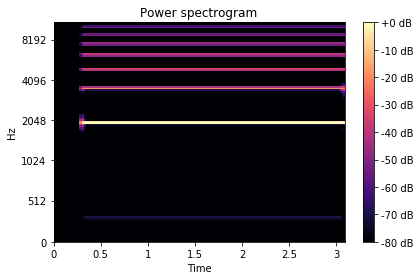

In [145]:
audio = wavload.readwav('/Users/josephcleveland/Desktop/Screech.wav')[2]
audio = audio.T[0]

X_audio = audio[0:67584].astype(float)
X_piano = np.zeros((1, 64, 64))
X_piano[0] = stft(X_audio,n_fft=1408)[0:64, 0:64]
X_piano = np.expand_dims(X_piano, axis=3)

Spectogram = np.abs(librosa.feature.melspectrogram(X_audio, sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

o = model.predict(X_piano)

In [115]:
average_dist = np.zeros(16)

for p in range(0, 16):
    dist_total = 0
    for i in range(0, 5000):
        dist_total += np.absolute(o[i, p] - Y_train[20000 + i, p])
    average_dist[p] = dist_total / 5000
    
print(average_dist)
print("average: ", np.average(average_dist))

[0.0619736  0.07603252 0.07315415 0.08408228 0.06194308 0.09956779
 0.09215607 0.10453552 0.0748385  0.08420107 0.08952909 0.09469274
 0.10232623 0.09887127 0.11902042 0.07292721]
average:  0.08686572062478293


In [125]:

vals = np.random.uniform(0, 1, 1000)
print(np.mean(vals))
print(Y_train[5])
print(o[5])
print(Y_train[5, 0] * 32 * 32)

0.48983281379878524
[0.02246094 0.098      0.51       0.203      0.602      0.821
 0.667      0.374      0.211      0.353      0.962      0.052
 0.785      0.852      0.649      0.779     ]
[0.05464076 0.10908591 0.54581136 0.47049633 0.7130788  0.5762943
 0.574171   0.5971361  0.3758217  0.43692404 1.0267307  0.5431005
 0.6158145  0.6210662  0.574561   0.56807566]
23.0


In [91]:
o[:, 0] = o[:, 0] * 32 * 32

np.savetxt("/Users/josephcleveland/FMData/predictions.csv", o, delimiter=",")

In [279]:
# Save the weights
model.save_weights('Regression1_weights.h5')

# Save the model architecture
with open('Regression1_architecture.json', 'w') as f:
    f.write(model.to_json())